In [2]:
import torch
import matplotlib.pyplot as plt
x = torch.arange(4.0)
x.requires_grad_(True)
x.grad
y = 2*torch.dot(x,x)
y.backward()
x.grad
x.grad == 4 * x
# 在默认情况下，PyTorch会累积梯度，我们需要清除之前的值
x.grad.zero_()
y = x*x
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

In [ ]:
# 分离计算
x.grad.zero_()
y = x * x
print(y)
u = y.detach()
print(u)   # u和y一样，只是丢弃了计算图中如何计算y的信息
# tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)
# tensor([0., 1., 4., 9.])
z = u * x
z.sum().backward()
x.grad == u

In [ ]:
# python控制流的梯度计算

def f(a):
    b = a*2
    while b.norm()<1000:
        b=b*2
    if b.sum()>0:
        c = b
    else:
        c = 100*b
    return c


a = torch.randn(size=(), requires_grad=True)
print(a)
d = f(a)
print(d)
d.backward()
a.grad == d / a

In [ ]:
# test
# 1、为什么计算二阶导数比一阶导数的开销要更大
'''
· 计算图的构建：在计算一阶导数时，PyTorch 只需要构建一次计算图，然后根据需要进行反向传播即可。而在计算二阶导数时，需要构建两次计算图，第一次是计算一阶导数，第二次是计算一阶导数的导数，也就是二阶导数。因此，计算二阶导数需要更多的计算图构建操作。
· 内存占用：计算一阶导数时，PyTorch 只需要保留一阶导数的梯度值，而计算二阶导数时需要保留一阶导数和二阶导数的梯度值，这会占用更多的内存。
· 计算量增加：计算二阶导数需要对一阶导数进行额外的计算，这增加了计算量和计算时间。
'''


# 2、在运行反向传播函数之后，立即再次运行它，看看会发生什么。
x = torch.arange(4.0,requires_grad=True)
y = torch.dot(x,x).sqrt()
print(x)
y.backward(retain_graph=True) 
# <- y.backward() 
'''
在运行反向传播函数之后，
立即再次运行它，会报错，
提示“尝试第二次反向传播
（或者在释放保存的张量后直接访问它们）。
调用.backward()或autograd.grad()时，
将释放图中保存的中间值。
如果需要第二次执行反向传播，
或者在反向传播调用后需要访问保存的张量，
请指定retain_graph=True。
'''
print(x.grad)
try:
    y.backward()
    print(x.grad)
except Exception as e:
    print(e)

# 3、在控制流的例子中，我们计算d关于a的导数，如果将变量a更改为随机向量或矩阵，会发生什么？
def f(a):
    b = a*2
    while b.norm()<1000:
        b=b*2
    if b.sum()>0:
        c = b
    else:
        c = 100*b
    return c


a = torch.arange(4.0, requires_grad=True)
# 出现错误：grad can be implicitly created only for scalar outputs
# PyTorch只能对标量结果求梯度
print(a)
d = f(a)
try:
    d.backward(torch.ones_like(d))  # <-d.backward()
except Exception as e:
    print(e)
print(a.grad)

In [ ]:
# 4、重新设计一个求控制流梯度的例子，运行并分析结果。
def f(a):
    b = a*2
    print(b)
    while b.norm()<1000:
        print('1')
        b=b*2
    if b.sum()>0:
        c = b
    else:
        c = 100*b
    print(c)
    return c.sum()
a = torch.randn(size=(), requires_grad=True)
d = f(a)
print(d)
d.backward()
print(a.grad)

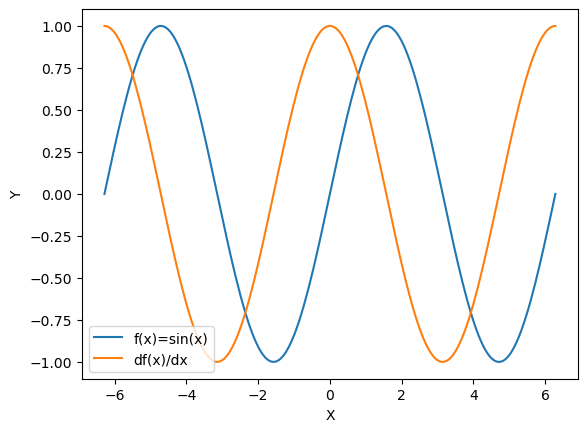

In [1]:
import matplotlib.pyplot as plt
# 5、f(x) = six(x), 绘制f(x)和对x求导，其中后者不使用f的导数为cos(x)
import os
import torch
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
def f(x):
    return torch.sin(x)

def df(x):
    x.requires_grad_()
    y = f(x)
    y.backward(torch.ones_like(y))
    return x.grad

x = torch.linspace(-2*torch.pi, 2*torch.pi, 200)

y1 = f(x)
y2 = df(x)

plt.plot(x.detach().numpy(), y1.detach().numpy(), label='f(x)=sin(x)')
plt.plot(x.detach().numpy(), y2.detach().numpy(), label='df(x)/dx')
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.show()